In [2]:
import os
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

Failed to import duecredit due to No module named 'duecredit'
/home/zohyos7/anaconda3/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


In [12]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')

subject_list = [sub[-4:] for sub in subject_list]

In [14]:
experiment_dir = '/home/zohyos7/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

# task name
task_list = ['empathy']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/opt/spm12/tpm/TPM.nii'

In [15]:
# Gunzip - unzip the anatomical image# Gunzip 
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

In [16]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name','fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                        'fwhm-{fwhm_id}_sasub-{subject_id}_task-{task_name}_bold.nii'),
             'anat': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}', 
                         'sub-{subject_id}_T1w_brain.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [17]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('func', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

180910-13:17:52,947 nipype.workflow INFO:
	 Generated workflow graph: /home/zohyos7/wellbeing_analysis/workingdir/spmflow/graph.png (graph2use=colored, simple_form=True).


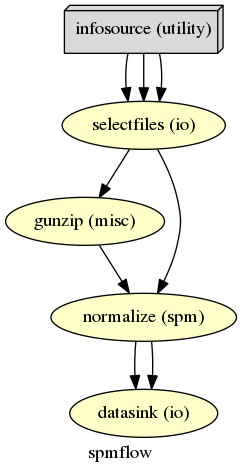

In [18]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.png'))


180910-13:17:55,640 nipype.workflow INFO:
	 Generated workflow graph: /home/zohyos7/wellbeing_analysis/workingdir/spmflow/graph.png (graph2use=flat, simple_form=True).


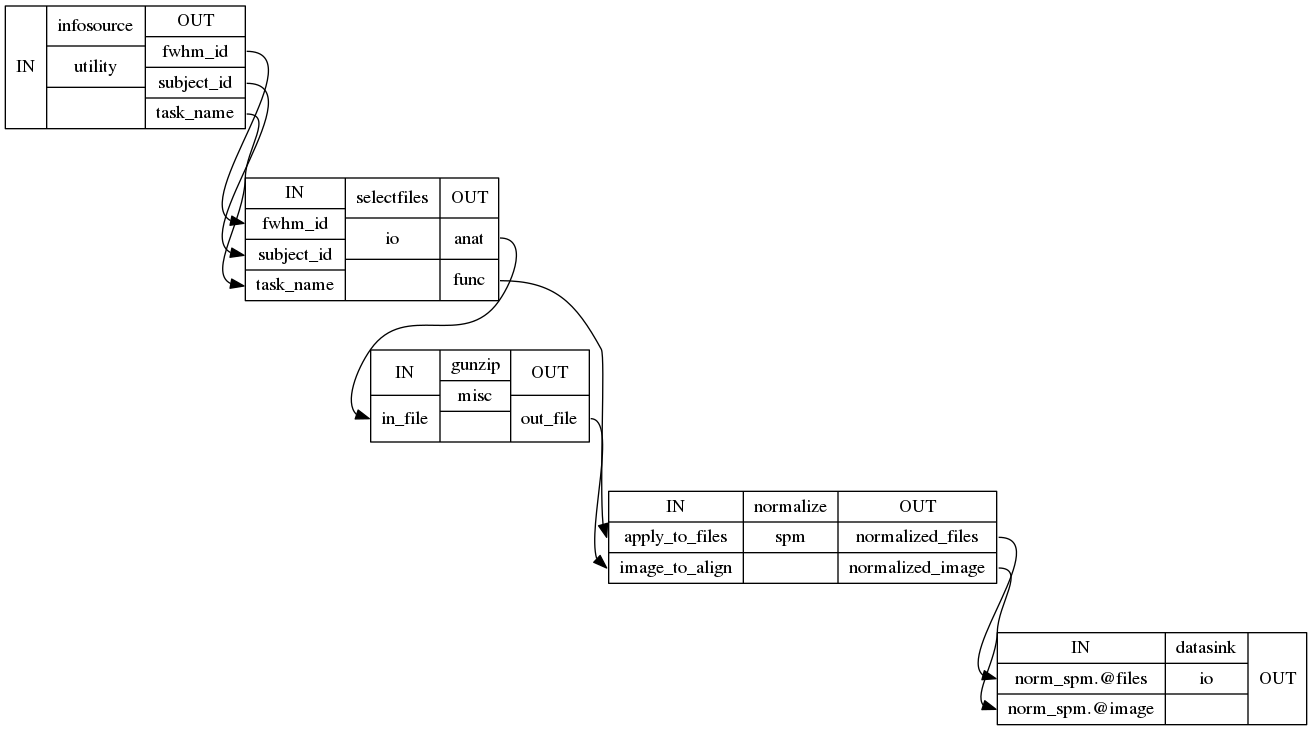

In [19]:
# Visualize the detailed graph# Visua # Visual 
spmflow.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph_detailed.png'))

In [ ]:
spmflow.run('MultiProc', plugin_args={'n_procs': 8})

180910-13:17:56,657 nipype.workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging', 'monitoring']
180910-13:18:02,889 nipype.workflow INFO:
	 Running in parallel.
180910-13:18:02,935 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 498 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
180910-13:18:03,75 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/zohyos7/wellbeing_analysis/workingdir/spmflow/_fwhm_id_8_subject_id_2677_task_name_empathy/selectfiles".180910-13:18:03,77 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/zohyos7/wellbeing_analysis/workingdir/spmflow/_fwhm_id_4_subject_id_2677_task_name_empathy/selectfiles".

180910-13:18:03,79 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/zohyos7/wellbeing_analysis/workingdir/spmflow/_fwhm_id_8_subject_id_3140_task_name_empathy/selectfiles".180910-13:18:03,81 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selec

## Compare SPM Normalization vs. ANT Normalization

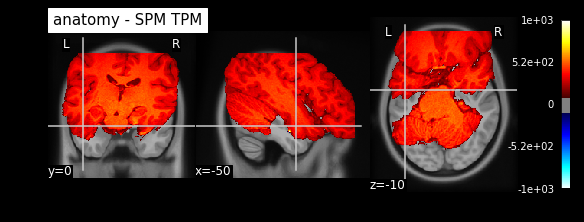

In [1]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
plot_stat_map(
    '/home/zohyos7/wellbeing_analysis/datasink/norm_spm/sub-2528_fwhm4_task_name_empathy/wsub-2528_T1w_brain.nii',
    title='anatomy - SPM TPM', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=100, display_mode='ortho', cut_coords=(-50, 0, -10))

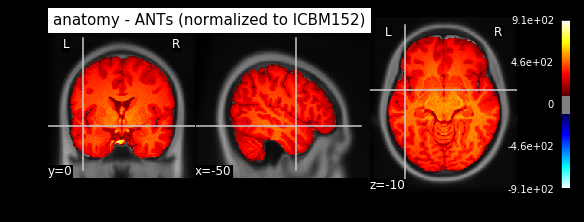

In [6]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
plot_stat_map(
    '/home/zohyos7/wellbeing_analysis/datasink/antsflow/sub-2528/anat/sub-2528_T1w_brain_trans.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=100, display_mode='ortho', cut_coords=(-50, 0, -10))